# Find cell centroids, plot over time (batch)
Take tracked cell timelapses, plot cell centroid positions over time as tracks in 2D space

* Author: Audrey Williams
* Created: 2022-08-08
* Purpose: Visualize cell movements in 2D, check for tracking errors


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from imageio import volread, imwrite
from skimage.measure import regionprops
import sys

sys.path.append('../code/')
from functions.utils import select_files


### Import tracked timelapses

In [2]:
OUTPUT = False
DATA_DIR = "/Users/sierraschwabach/Documents/new_n1032"
OUT_DIR = "/Users/sierraschwabach/Documents/new_n1032/"

KEYS = ["_tracked_reg.tif"]

datasets = select_files(DATA_DIR, KEYS)

## Find centroids, store as dataframe

In [5]:
datasets = select_files(DATA_DIR, KEYS)
for dataset in datasets:
    basename = dataset['basename']
    ims_tracked = volread(dataset["_tracked_reg.tif"])
    dataset["ims_tracked"] = ims_tracked
    print(f"Finding centroids for {basename}")

    # Make DataFrame with cell label, centroid coords, frame number
    # Background (region with ID == 0) is excluded
    df_frame_list = []
    for i in range(len(ims_tracked)):
        labels = []
        centroid_rows = []
        centroid_cols = []
        for region in regionprops(ims_tracked[i]):
            label = region.label
            labels.append(label)
            centroid_row, centroid_col = region.centroid
            centroid_rows.append(centroid_row)
            centroid_cols.append(centroid_col)

        df_frame = pd.DataFrame({"cell":labels,
                           "centroid_row":centroid_rows,
                           "centroid_col":centroid_cols,
                           "frame":i})
        df_frame_list.append(df_frame)

    df_timelapse = pd.concat(df_frame_list)
    dataset["df_centroids"] = df_timelapse

    df_path = (OUT_DIR + basename + '_centroids.csv')
    df_timelapse.to_csv(path_or_buf = df_path)


Finding centroids for Exp717_05


## Plot centroids over time
One line per cell. Plot dimensions match 1 frame of timelapse. 

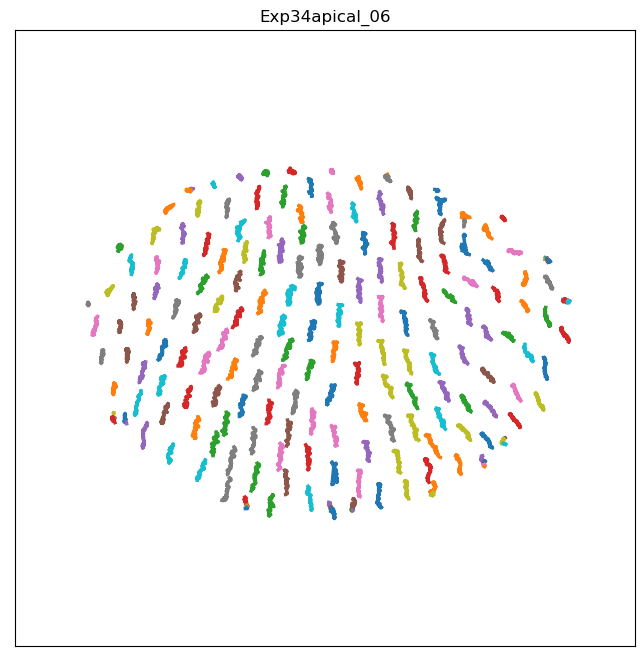

In [13]:
for dataset in datasets:
    basename = dataset["basename"]
    df_centroids = dataset["df_centroids"]
    ims_tracked = dataset["ims_tracked"]

    fig, ax = plt.subplots(figsize=(8,8))
    cells = np.unique(df_centroids["cell"])
    for i in range(len(cells)):
        cell = cells[i]
        df_cell = df_centroids[df_centroids['cell'] == cell]
        ax.plot(df_cell['centroid_col'],df_cell['centroid_row'], linewidth=2.5)

    # Adjust axis range, labeling
    plt.gca().invert_yaxis()
    ax.set_xlim(0,len(ims_tracked[0,0,:]))
    ax.set_ylim(len(ims_tracked[0,:]),0)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if OUTPUT == True:
        out_path = os.path.join(OUT_DIR, f"{basename}_centroid_tracks.png")
        plt.savefig(out_path, dpi=300, transparent = True)
        plt.close(fig)

    else: 
        ax.set_title(basename)


In [3]:
# Function to process CSV files in a folder
def process_csv_files(input_folder, output_folder):
    # List all CSV files in the input folder
    csv_files = [file for file in os.listdir(input_folder) if file.endswith('.csv')]

    # Process each CSV file
    for csv_file in csv_files:
        # Read the CSV file
        df_centroids_cvs = pd.read_csv(os.path.join(input_folder, csv_file))

        # Perform filtering
        basename = os.path.splitext(csv_file)[0]
        g = df_centroids_cvs.groupby('cell')
        df2 = g.filter(lambda x: len(x) > 10)

        # Define output path
        df_path = os.path.join(output_folder, f"{basename}_centroids_cells10_removed.csv")

        # Save filtered data to CSV
        df2.to_csv(df_path, index=False)
        print(f"Filtered data saved to: {df_path}")

# Specify input and output folders
input_folder = '/Users/sierraschwabach/Documents/new_n1032'
output_folder = '/Users/sierraschwabach/Documents/new_n1032/'

# Process CSV files
process_csv_files(input_folder, output_folder)


Filtered data saved to: /Users/sierraschwabach/Documents/new_n1032/Exp717_05_centroids_tmp_reg_r_centroids_cells10_removed.csv


In [8]:
# Function to process CSV files in a folder
def process_csv_files(input_folder, output_folder):
    # List all CSV files in the input folder
    csv_files = [file for file in os.listdir(input_folder) if file.endswith('_cells10_removed.csv')]

    # Process each CSV file
    for csv_file in csv_files:
        # Read the CSV file
        df_centroids_cvs = pd.read_csv(os.path.join(input_folder, csv_file))

        # Extract basename
        basename = os.path.splitext(csv_file)[0]

        # Plot centroid tracks
        fig, ax = plt.subplots(figsize=(8, 8))
        cells = np.unique(df_centroids_cvs["cell"])

        for i in range(len(cells)):
            cell = cells[i]
            df_cell = df_centroids_cvs[df_centroids_cvs['cell'] == cell]
            ax.plot(df_cell['centroid_col'], df_cell['centroid_row'], linewidth=2.5)

        # Adjust axis range, labeling
        plt.gca().invert_yaxis()
        ax.set_xlim(0, len(ims_tracked[0, 0, :]))
        ax.set_ylim(len(ims_tracked[0, :]), 0)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Save or display the plot
        if OUTPUT == True:
            out_path = os.path.join(output_folder, f"{basename}_centroid_2.5_tracks.png")
            plt.savefig(out_path, dpi=300, transparent=True)
            plt.close(fig)
            print(f"Plot saved to: {out_path}")
        else:
            ax.set_title(basename)
            plt.show()

# Specify input and output folders
input_folder = '/Users/sierraschwabach/Documents/new_n1032'
output_folder = '/Users/sierraschwabach/Documents/new_n1032/'

# Set OUTPUT flag
OUTPUT = True  # Change to False if you want to display plots instead of saving them

# Process CSV files
process_csv_files(input_folder, output_folder)


Plot saved to: /Users/sierraschwabach/Documents/new_n1032/Exp717_05_centroids_tmp_reg_r_centroids_cells10_removed_centroid_2.5_tracks.png
